In [ ]:
!pip install TensorFlow==2.8.0

In [ ]:
!pip install pydot
!pip install pydotplus
!pip install graphviz

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# utils and preprocessing
##### credit: In the following sections of code, some preprocessing and util code were adapted from fnc-1-baseline (https://github.com/FakeNewsChallenge/fnc-1-baseline) and UCL Machine Reading - FNC-1 Submission (https://github.com/uclnlp/fakenewschallenge). Specifically, funcitons to generate the features  word overlap, refuting, polarity, and co-occurrences were adopted from the baseline code. Functions and classes to preprocess and generate TF vectors and cos similiarity are adopted from UCL Machine Reading - FNC-1 Submission. However, both are modifed to serve our design. 

In [ ]:
##### credit: In the following sections of code, some preprocessing and util code were adapted from fnc-1-baseline (https://github.com/FakeNewsChallenge/fnc-1-baseline) and UCL Machine Reading - FNC-1 Submission (https://github.com/uclnlp/fakenewschallenge). Specifically, funcitons to generate the features  word overlap, refuting, polarity, and co-occurrences were adopted from the baseline code. Functions and classes to preprocess and generate TF vectors and cos similiarity are adopted from UCL Machine Reading - FNC-1 Submission. However, both are modifed to serve our design. 

# the following code is from baseline

import os
import re
import nltk
import numpy as np
from sklearn import feature_extraction
from tqdm import tqdm


_wnl = nltk.WordNetLemmatizer()


def normalize_word(w):
    return _wnl.lemmatize(w).lower()


def get_tokenized_lemmas(s):
    return [normalize_word(t) for t in nltk.word_tokenize(s)]


def clean(s):
    # Cleans a string: Lowercasing, trimming, removing non-alphanumeric

    return " ".join(re.findall(r'\w+', s, flags=re.UNICODE)).lower()


def remove_stopwords(l):
    # Removes stopwords from a list of tokens
    return [w for w in l if w not in feature_extraction.text.ENGLISH_STOP_WORDS]


def gen_or_load_feats(feat_fn, headlines, bodies, feature_file):
    if not os.path.isfile(feature_file):
        feats = feat_fn(headlines, bodies)
        np.save(feature_file, feats)

    return np.load(feature_file)




def word_overlap_features(headlines, bodies):
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        clean_headline = get_tokenized_lemmas(clean_headline)
        clean_body = get_tokenized_lemmas(clean_body)
        features = [
            len(set(clean_headline).intersection(clean_body)) / float(len(set(clean_headline).union(clean_body)))]
        X.append(features)
    return X


def refuting_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        # 'refute',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_headline = get_tokenized_lemmas(clean_headline)
        features = [1 if word in clean_headline else 0 for word in _refuting_words]
        X.append(features)
    return X


def polarity_features(headlines, bodies):
    _refuting_words = [
        'fake',
        'fraud',
        'hoax',
        'false',
        'deny', 'denies',
        'not',
        'despite',
        'nope',
        'doubt', 'doubts',
        'bogus',
        'debunk',
        'pranks',
        'retract'
    ]

    def calculate_polarity(text):
        tokens = get_tokenized_lemmas(text)
        return sum([t in _refuting_words for t in tokens]) % 2
    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        clean_headline = clean(headline)
        clean_body = clean(body)
        features = []
        features.append(calculate_polarity(clean_headline))
        features.append(calculate_polarity(clean_body))
        X.append(features)
    return np.array(X)


def ngrams(input, n):
    input = input.split(' ')
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def chargrams(input, n):
    output = []
    for i in range(len(input) - n + 1):
        output.append(input[i:i + n])
    return output


def append_chargrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in chargrams(" ".join(remove_stopwords(text_headline.split())), size)]
    grams_hits = 0
    grams_early_hits = 0
    grams_first_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
        if gram in text_body[:100]:
            grams_first_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    features.append(grams_first_hits)
    return features


def append_ngrams(features, text_headline, text_body, size):
    grams = [' '.join(x) for x in ngrams(text_headline, size)]
    grams_hits = 0
    grams_early_hits = 0
    for gram in grams:
        if gram in text_body:
            grams_hits += 1
        if gram in text_body[:255]:
            grams_early_hits += 1
    features.append(grams_hits)
    features.append(grams_early_hits)
    return features


def hand_features(headlines, bodies):

    def binary_co_occurence(headline, body):
        # Count how many times a token in the title
        # appears in the body text.
        bin_count = 0
        bin_count_early = 0
        for headline_token in clean(headline).split(" "):
            if headline_token in clean(body):
                bin_count += 1
            if headline_token in clean(body)[:255]:
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def binary_co_occurence_stops(headline, body):
        # Count how many times a token in the title
        # appears in the body text. Stopwords in the title
        # are ignored.
        bin_count = 0
        bin_count_early = 0
        for headline_token in remove_stopwords(clean(headline).split(" ")):
            if headline_token in clean(body):
                bin_count += 1
                bin_count_early += 1
        return [bin_count, bin_count_early]

    def count_grams(headline, body):
        # Count how many times an n-gram of the title
        # appears in the entire body, and intro paragraph

        clean_body = clean(body)
        clean_headline = clean(headline)
        features = []
        features = append_chargrams(features, clean_headline, clean_body, 2)
        features = append_chargrams(features, clean_headline, clean_body, 8)
        features = append_chargrams(features, clean_headline, clean_body, 4)
        features = append_chargrams(features, clean_headline, clean_body, 16)
        features = append_ngrams(features, clean_headline, clean_body, 2)
        features = append_ngrams(features, clean_headline, clean_body, 3)
        features = append_ngrams(features, clean_headline, clean_body, 4)
        features = append_ngrams(features, clean_headline, clean_body, 5)
        features = append_ngrams(features, clean_headline, clean_body, 6)
        return features

    X = []
    for i, (headline, body) in tqdm(enumerate(zip(headlines, bodies))):
        X.append(binary_co_occurence(headline, body)
                 + binary_co_occurence_stops(headline, body)
                 + count_grams(headline, body))


    return X


In [ ]:
##### credit: In the following sections of code, some preprocessing and util code were adapted from fnc-1-baseline (https://github.com/FakeNewsChallenge/fnc-1-baseline) and UCL Machine Reading - FNC-1 Submission (https://github.com/uclnlp/fakenewschallenge). Specifically, funcitons to generate the features  word overlap, refuting, polarity, and co-occurrences were adopted from the baseline code. Functions and classes to preprocess and generate TF vectors and cos similiarity are adopted from UCL Machine Reading - FNC-1 Submission. However, both are modifed to serve our design. 

# the following code is adopted and modified from UCL Machine Reading - FNC-1 Submission (https://github.com/uclnlp/fakenewschallenge)



# Copyright 2017 Benjamin Riedel
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Import relevant packages and modules
from csv import DictReader
from csv import DictWriter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf


# Initialise global variables
label_ref = {'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3}
# label_ref_keras = {'agree': [1,0,0,0], 'disagree': [0,1,0,0], 'discuss': [0,0,1,0], 'unrelated': [0,0,0,1]}
label_ref_keras = {'agree': [1,0], 'disagree': [1,0], 'discuss': [1,0], 'unrelated': [0,1]}
label_ref_rev = {0: 'agree', 1: 'disagree', 2: 'discuss', 3: 'unrelated'}
stop_words = [
        "a", "about", "above", "across", "after", "afterwards", "again", "against", "all", "almost", "alone", "along",
        "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "another",
        "any", "anyhow", "anyone", "anything", "anyway", "anywhere", "are", "around", "as", "at", "back", "be",
        "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "behind", "being",
        "below", "beside", "besides", "between", "beyond", "bill", "both", "bottom", "but", "by", "call", "can", "co",
        "con", "could", "cry", "de", "describe", "detail", "do", "done", "down", "due", "during", "each", "eg", "eight",
        "either", "eleven", "else", "elsewhere", "empty", "enough", "etc", "even", "ever", "every", "everyone",
        "everything", "everywhere", "except", "few", "fifteen", "fifty", "fill", "find", "fire", "first", "five", "for",
        "former", "formerly", "forty", "found", "four", "from", "front", "full", "further", "get", "give", "go", "had",
        "has", "have", "he", "hence", "her", "here", "hereafter", "hereby", "herein", "hereupon", "hers", "herself",
        "him", "himself", "his", "how", "however", "hundred", "i", "ie", "if", "in", "inc", "indeed", "interest",
        "into", "is", "it", "its", "itself", "keep", "last", "latter", "latterly", "least", "less", "ltd", "made",
        "many", "may", "me", "meanwhile", "might", "mill", "mine", "more", "moreover", "most", "mostly", "move", "much",
        "must", "my", "myself", "name", "namely", "neither", "nevertheless", "next", "nine", "nobody", "now", "nowhere",
        "of", "off", "often", "on", "once", "one", "only", "onto", "or", "other", "others", "otherwise", "our", "ours",
        "ourselves", "out", "over", "own", "part", "per", "perhaps", "please", "put", "rather", "re", "same", "see",
        "serious", "several", "she", "should", "show", "side", "since", "sincere", "six", "sixty", "so", "some",
        "somehow", "someone", "something", "sometime", "sometimes", "somewhere", "still", "such", "system", "take",
        "ten", "than", "that", "the", "their", "them", "themselves", "then", "thence", "there", "thereafter", "thereby",
        "therefore", "therein", "thereupon", "these", "they", "thick", "thin", "third", "this", "those", "though",
        "three", "through", "throughout", "thru", "thus", "to", "together", "too", "top", "toward", "towards", "twelve",
        "twenty", "two", "un", "under", "until", "up", "upon", "us", "very", "via", "was", "we", "well", "were", "what",
        "whatever", "when", "whence", "whenever", "where", "whereafter", "whereas", "whereby", "wherein", "whereupon",
        "wherever", "whether", "which", "while", "whither", "who", "whoever", "whole", "whom", "whose", "why", "will",
        "with", "within", "without", "would", "yet", "you", "your", "yours", "yourself", "yourselves"
        ]

def score_submission(gold_labels, test_labels):
    score = 0.0
    cm = [[0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0],
          [0, 0, 0, 0]]

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25

        cm[LABELS.index(g_stance)][LABELS.index(t_stance)] += 1

    return score, cm


def print_confusion_matrix(cm):
    lines = []
    header = "|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format('', *LABELS)
    line_len = len(header)
    lines.append("-"*line_len)
    lines.append(header)
    lines.append("-"*line_len)

    hit = 0
    total = 0
    for i, row in enumerate(cm):
        hit += row[i]
        total += sum(row)
        lines.append("|{:^11}|{:^11}|{:^11}|{:^11}|{:^11}|".format(LABELS[i],
                                                                   *row))
        lines.append("-"*line_len)
    print('\n'.join(lines))


def report_score(actual,predicted):
    score,cm = score_submission(actual,predicted)
    best_score, _ = score_submission(actual,actual)

    print_confusion_matrix(cm)
    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score

# Define data class
class FNCData:

    """

    Define class for Fake News Challenge data

    """

    def __init__(self, instances_input, bodies_input):

        # Load data
        self.instances = instances_input
        bodies = bodies_input
        self.heads = {}
        self.bodies = {}

        # Process instances
        for instance in self.instances:
            if instance['Headline'] not in self.heads:
                head_id = len(self.heads)
                self.heads[instance['Headline']] = head_id
            instance['Body ID'] = int(instance['Body ID'])

        # Process bodies
        for body in bodies:
            self.bodies[int(body['Body ID'])] = body['articleBody']

    def read(self, filename):

        """
        Read Fake News Challenge data from CSV file

        Args:
            filename: str, filename + extension

        Returns:
            rows: list, of dict per instance

        """

        # Initialise
        rows = []

        # Process file
        with open(filename, "r", encoding='utf-8') as table:
            r = DictReader(table)
            for line in r:
                rows.append(line)

        return rows


# Define relevant functions
def pipeline_train(train, test, lim_unigram):

    # Initialise
    heads = []
    heads_track = {}
    bodies = []
    bodies_track = {}
    body_ids = []
    id_ref = {}
    train_set = []
    train_stances = []
    cos_track = {}
    test_heads = []
    test_heads_track = {}
    test_bodies = []
    test_bodies_track = {}
    test_body_ids = []
    head_tfidf_track = {}
    body_tfidf_track = {}
    tfidf_cos_ls = []

    # Identify unique heads and bodies
    for instance in train.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in heads_track:
            heads.append(head)
            heads_track[head] = 1
        if body_id not in bodies_track:
            bodies.append(train.bodies[body_id])
            bodies_track[body_id] = 1
            body_ids.append(body_id)

    for instance in test.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in test_heads_track:
            test_heads.append(head)
            test_heads_track[head] = 1
        if body_id not in test_bodies_track:
            test_bodies.append(test.bodies[body_id])
            test_bodies_track[body_id] = 1
            test_body_ids.append(body_id)

    # Create reference dictionary
    for i, elem in enumerate(heads + body_ids):
        id_ref[elem] = i

    # Create vectorizers and BOW and TF arrays for train set
    bow_vectorizer = CountVectorizer(max_features=lim_unigram, stop_words=stop_words)
    bow = bow_vectorizer.fit_transform(heads + bodies)  # Train set only

    tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
    tfreq = tfreq_vectorizer.transform(bow).toarray()  # Train set only

    tfidf_vectorizer = TfidfVectorizer(max_features=lim_unigram, stop_words=stop_words).\
        fit(heads + bodies + test_heads + test_bodies)  # Train and test sets

    # Process train set
    for instance in train.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        head_tf = tfreq[id_ref[head]].reshape(1, -1)
        body_tf = tfreq[id_ref[body_id]].reshape(1, -1)
        if head not in head_tfidf_track:
            head_tfidf = tfidf_vectorizer.transform([head]).toarray()
            head_tfidf_track[head] = head_tfidf
        else:
            head_tfidf = head_tfidf_track[head]
        if body_id not in body_tfidf_track:
            body_tfidf = tfidf_vectorizer.transform([train.bodies[body_id]]).toarray()
            body_tfidf_track[body_id] = body_tfidf
        else:
            body_tfidf = body_tfidf_track[body_id]
        if (head, body_id) not in cos_track:
            tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
            cos_track[(head, body_id)] = tfidf_cos
        else:
            tfidf_cos = cos_track[(head, body_id)]
        # feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        feat_vec = np.squeeze(np.c_[head_tf, body_tf])
        tfidf_cos_ls.append(tfidf_cos)
        train_set.append(feat_vec)
        # train_stances.append(label_ref[instance['Stance']])
        train_stances.append(label_ref_keras[instance['Stance']])

    return train_set, train_stances, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer, tfidf_cos_ls


def pipeline_test_with_stance(test, bow_vectorizer, tfreq_vectorizer, tfidf_vectorizer):

    # Initialise
    test_set = []
    test_stances = []
    heads_track = {}
    bodies_track = {}
    cos_track = {}
    test_cos = []

    # Process test set
    for instance in test.instances:
        head = instance['Headline']
        body_id = instance['Body ID']
        if head not in heads_track:
            head_bow = bow_vectorizer.transform([head]).toarray()
            head_tf = tfreq_vectorizer.transform(head_bow).toarray()[0].reshape(1, -1)
            head_tfidf = tfidf_vectorizer.transform([head]).toarray().reshape(1, -1)
            heads_track[head] = (head_tf, head_tfidf)
        else:
            head_tf = heads_track[head][0]
            head_tfidf = heads_track[head][1]
        if body_id not in bodies_track:
            body_bow = bow_vectorizer.transform([test.bodies[body_id]]).toarray()
            body_tf = tfreq_vectorizer.transform(body_bow).toarray()[0].reshape(1, -1)
            body_tfidf = tfidf_vectorizer.transform([test.bodies[body_id]]).toarray().reshape(1, -1)
            bodies_track[body_id] = (body_tf, body_tfidf)
        else:
            body_tf = bodies_track[body_id][0]
            body_tfidf = bodies_track[body_id][1]
        if (head, body_id) not in cos_track:
            tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
            cos_track[(head, body_id)] = tfidf_cos
        else:
            tfidf_cos = cos_track[(head, body_id)]
        # feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        feat_vec = np.squeeze(np.c_[head_tf, body_tf])
        test_cos.append(tfidf_cos)
        test_set.append(feat_vec)
        # test_stances.append(label_ref[instance['Stance']])
        test_stances.append(label_ref_keras[instance['Stance']])


    return test_set, test_stances, test_cos

def load_model(sess):
    saver = tf.train.Saver()
    saver.restore(sess, './model/model.checkpoint')


def save_predictions(pred, file):
    with open(file, 'w') as csvfile:
        fieldnames = ['Stance']
        writer = DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for instance in pred:
            writer.writerow({'Stance': label_ref_rev[instance]})




# Generate Features

#### credit: TF Vector and TF cos similiarity features are adpated from UCL Machine Reading - FNC-1 Submission (https://github.com/uclnlp/fakenewschallenge)  

In [ ]:
##### credit: In the following sections of code, some preprocessing and util code were adapted from fnc-1-baseline (https://github.com/FakeNewsChallenge/fnc-1-baseline) and UCL Machine Reading - FNC-1 Submission (https://github.com/uclnlp/fakenewschallenge). Specifically, funcitons to generate the features  word overlap, refuting, polarity, and co-occurrences were adopted from the baseline code. Functions and classes to preprocess and generate TF vectors and cos similiarity are adopted from UCL Machine Reading - FNC-1 Submission. However, both are modifed to serve our design. 

# the following code is adopted and modified from UCL Machine Reading - FNC-1 Submission (https://github.com/uclnlp/fakenewschallenge)

from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_VOCAB_SIZE = 5000
local = False

if local:
    EMB_DIR = "data/glove.6B.50d.txt"
    FEATURES_DIR = "features"
else:
    EMB_DIR = "drive/MyDrive/4B/MSCI 598/Project/data/glove.6B.50d.txt"
    FEATURES_DIR = "drive/MyDrive/4B/MSCI 598/Project/features"
EMBEDDING_DIM = 50

def read(filename):
    rows = []
    # Process file
    with open(filename, "r", encoding='utf-8') as table:
        r = DictReader(table)
        for line in r:
            rows.append(line)

    return rows

def preprocess(train, test):

  lim_unigram = 5000

  train_h = []
  train_b = []
  train_s = []
  test_h = []
  test_b = []
  test_s = []
  all = []

  heads = []
  heads_track = {}
  bodies = []
  bodies_track = {}
  body_ids = []
  id_ref = {}
  train_tf = []
  train_stances = []
  cos_track = {}
  test_heads_track = {}
  test_tf = []
  test_heads = []
  test_bodies = []
  test_bodies_track = {}
  test_body_ids = []
  head_tfidf_track = {}
  body_tfidf_track = {}
  train_cos = []
  test_cos = []

  train_heads = []
  train_bodies = []
  test_heads = []
  test_bodies = []

  
  max_sent_len = 0
  for instance in train.instances:

    # Identify unique heads and bodies
    head = instance['Headline']
    body_id = instance['Body ID']
    if head not in heads_track:
        heads.append(head)
        heads_track[head] = 1
    if body_id not in bodies_track:
        bodies.append(train.bodies[body_id])
        bodies_track[body_id] = 1
        body_ids.append(body_id)
  
  for instance in test.instances:

    head = instance['Headline']
    body_id = instance['Body ID']
    if head not in test_heads_track:
        test_heads.append(head)
        test_heads_track[head] = 1
    if body_id not in test_bodies_track:
        test_bodies.append(test.bodies[body_id])
        test_bodies_track[body_id] = 1
        test_body_ids.append(body_id)

  # Create reference dictionary
  for i, elem in enumerate(heads + body_ids):
      id_ref[elem] = i

  # Create vectorizers and BOW and TF arrays for train set
  bow_vectorizer = CountVectorizer(max_features=lim_unigram, stop_words=stop_words)
  bow = bow_vectorizer.fit_transform(heads + bodies)  # Train set only

  tfreq_vectorizer = TfidfTransformer(use_idf=False).fit(bow)
  tfreq = tfreq_vectorizer.transform(bow).toarray()  # Train set only

  tfidf_vectorizer = TfidfVectorizer(max_features=lim_unigram, stop_words=stop_words).\
    fit(heads + bodies + test_heads + test_bodies)  # Train and test sets
  
  test_heads = []
  test_bodies = []

  for instance in train.instances:
    all.append(instance['Headline'])
    all.append(train.bodies[instance['Body ID']])

    train_h.append(instance['Headline'])
    train_b.append(train.bodies[instance['Body ID']])
    train_s.append(label_ref_keras[instance['Stance']])

    train_heads.append(instance['Headline'])
    train_bodies.append(train.bodies[instance['Body ID']])

    max_sent_len = max(max_sent_len, len(instance['Headline'].split()))
    max_sent_len = max(max_sent_len, len(train.bodies[instance['Body ID']].split()))

    head = instance['Headline']
    body_id = instance['Body ID']
    head_tf = tfreq[id_ref[head]].reshape(1, -1)
    body_tf = tfreq[id_ref[body_id]].reshape(1, -1)
    if head not in head_tfidf_track:
        head_tfidf = tfidf_vectorizer.transform([head]).toarray()
        head_tfidf_track[head] = head_tfidf
    else:
        head_tfidf = head_tfidf_track[head]
    if body_id not in body_tfidf_track:
        body_tfidf = tfidf_vectorizer.transform([train.bodies[body_id]]).toarray()
        body_tfidf_track[body_id] = body_tfidf
    else:
        body_tfidf = body_tfidf_track[body_id]
    if (head, body_id) not in cos_track:
        tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
        cos_track[(head, body_id)] = tfidf_cos
    else:
        tfidf_cos = cos_track[(head, body_id)]
    # feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
    feat_vec = np.squeeze(np.c_[head_tf, body_tf])
    train_cos.append(tfidf_cos)
    train_tf.append(feat_vec)
    # train_stances.append(label_ref[instance['Stance']])
    # train_stances.append(label_ref_keras[instance['Stance']])
  
  # Initialise
  test_set = []
  test_stances = []
  heads_track = {}
  bodies_track = {}
  cos_track = {}
  test_cos = []

  # Process test set
  for instance in test.instances:
    all.append(instance['Headline'])
    all.append(test.bodies[instance['Body ID']])

    test_h.append(instance['Headline'])
    test_b.append(test.bodies[instance['Body ID']])
    test_s.append(label_ref_keras[instance['Stance']])

    test_heads.append(instance['Headline'])
    test_bodies.append(test.bodies[instance['Body ID']])

    max_sent_len = max(max_sent_len, len(instance['Headline'].split()))
    max_sent_len = max(max_sent_len, len(test.bodies[instance['Body ID']].split()))

    head = instance['Headline']
    body_id = instance['Body ID']
    if head not in heads_track:
        head_bow = bow_vectorizer.transform([head]).toarray()
        head_tf = tfreq_vectorizer.transform(head_bow).toarray()[0].reshape(1, -1)
        head_tfidf = tfidf_vectorizer.transform([head]).toarray().reshape(1, -1)
        heads_track[head] = (head_tf, head_tfidf)
    else:
        head_tf = heads_track[head][0]
        head_tfidf = heads_track[head][1]
    if body_id not in bodies_track:
        body_bow = bow_vectorizer.transform([test.bodies[body_id]]).toarray()
        body_tf = tfreq_vectorizer.transform(body_bow).toarray()[0].reshape(1, -1)
        body_tfidf = tfidf_vectorizer.transform([test.bodies[body_id]]).toarray().reshape(1, -1)
        bodies_track[body_id] = (body_tf, body_tfidf)
    else:
        body_tf = bodies_track[body_id][0]
        body_tfidf = bodies_track[body_id][1]
    if (head, body_id) not in cos_track:
        tfidf_cos = cosine_similarity(head_tfidf, body_tfidf)[0].reshape(1, 1)
        cos_track[(head, body_id)] = tfidf_cos
    else:
        tfidf_cos = cos_track[(head, body_id)]
    # feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
    feat_vec = np.squeeze(np.c_[head_tf, body_tf])
    test_cos.append(tfidf_cos)
    test_tf.append(feat_vec)
    # test_stances.append(label_ref[instance['Stance']])
    # test_stances.append(label_ref_keras[instance['Stance']])


  tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n') 
  tokenizer.fit_on_texts(all)

  word_index =  word_index = {k: v for k, v in tokenizer.word_index.items() if v < MAX_VOCAB_SIZE}
  idx_to_word = dict((v,k) for k,v in word_index.items())

  print("heads h test.instances len", len(test_heads), len(test_h), len(test.instances))

  train_h = tokenizer.texts_to_sequences(train_h)
  train_h = pad_sequences(train_h, maxlen=max_sent_len, padding='post', truncating='post')

  train_b = tokenizer.texts_to_sequences(train_b)
  train_b = pad_sequences(train_b, maxlen=max_sent_len, padding='post', truncating='post')

  test_h = tokenizer.texts_to_sequences(test_h)
  test_h = pad_sequences(test_h, maxlen=max_sent_len, padding='post', truncating='post')

  test_b = tokenizer.texts_to_sequences(test_b)
  test_b = pad_sequences(test_b, maxlen=max_sent_len, padding='post', truncating='post')
  
    
  train_word_overlap = gen_or_load_feats(word_overlap_features, train_heads, train_bodies, FEATURES_DIR + "/train/rel_unrel/overlap."+"overlap"+".npy")
  train_refuting = gen_or_load_feats(refuting_features, train_heads, train_bodies, FEATURES_DIR + "/train/rel_unrel/refuting."+"refuting"+".npy")
  train_polarity = gen_or_load_feats(polarity_features, train_heads, train_bodies, FEATURES_DIR + "/train/rel_unrel/polarity."+"polarity"+".npy")
  train_hand = gen_or_load_feats(hand_features, train_heads, train_bodies, FEATURES_DIR + "/train/rel_unrel/hand."+"hand"+".npy")
  
  test_word_overlap = gen_or_load_feats(word_overlap_features, test_heads, test_bodies, FEATURES_DIR + "/test/rel_unrel/overlap."+"overlap"+".npy")
  test_refuting = gen_or_load_feats(refuting_features, test_heads, test_bodies, FEATURES_DIR + "/test/rel_unrel/refuting."+"refuting"+".npy")
  test_polarity = gen_or_load_feats(polarity_features, test_heads, test_bodies, FEATURES_DIR + "/test/rel_unrel/polarity."+"polarity"+".npy")
  test_hand = gen_or_load_feats(hand_features, test_heads, test_bodies, FEATURES_DIR + "/test/rel_unrel/hand."+"hand"+".npy")

  print("heads h feat len", len(test_heads), len(test_h), len(test_hand))

  # Data path
  embeddings = {}
  f = open(EMB_DIR, encoding="utf8")
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], dtype='float32')
      embeddings[word] = vector
  f.close()

  embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

  for word, i in word_index.items(): # i=0 is the embedding for the zero padding
      try:
          embeddings_vector = embeddings[word]
      except KeyError:
          embeddings_vector = None
      if embeddings_vector is not None:
          embeddings_matrix[i] = embeddings_vector
          
  del embeddings


  return embeddings_matrix, train_h, train_b, train_s, \
  test_h, test_b, test_s, max_sent_len, train_tf, train_cos, \
  test_tf, test_cos, train_word_overlap, train_refuting, train_polarity, train_hand, \
  test_word_overlap, test_refuting, test_polarity, test_hand


# Load Data (Embedding Matrix)

In [ ]:
# from util import *
import random
import tensorflow as tf
from random import randrange

mode = 'train'

# Set file names
if local:
    file_train_bodies = "data/train_bodies.csv"
    file_train_instances = "data/train_stances.csv"
    file_test_instances = "data/competition_test_stances.csv"
    file_test_bodies = "data/competition_test_bodies.csv"
    file_predictions = "/predictions/NN_to_NN_predictions_test.csv"
else:
    file_train_bodies = "drive/MyDrive/4B/MSCI 598/Project/data/train_bodies.csv"
    file_train_instances = "drive/MyDrive/4B/MSCI 598/Project/data/train_stances.csv"
    file_test_instances = "drive/MyDrive/4B/MSCI 598/Project/data/competition_test_stances.csv"
    file_test_bodies = "drive/MyDrive/4B/MSCI 598/Project/data/competition_test_bodies.csv"
    file_predictions = "drive/MyDrive/4B/MSCI 598/Project/predictions/NN_to_NN_predictions_test.csv"


# Load data sets
train_instances = read(file_train_instances)
train_bodies = read(file_train_bodies)

# print(train_instances[0]['Stance'] == 'disagree')

train_disagree = [i for i in range(0, len(train_instances)) if train_instances[i]['Stance'] == 'disagree']
train_agree = [i for i in range(0, len(train_instances)) if train_instances[i]['Stance'] == 'agree']
# train_unrelated = [i for i in range(0, len(train_instances)) if train_instances[i]['Stance'] == 'unrelated']
# train_discuss = [i for i in range(0, len(train_instances)) if train_instances[i]['Stance'] == 'discuss']

# random.shuffle(train_unrelated)

# print(len(train_instances), len(train_disagree), len(train_agree), len(train_unrelated), len(train_discuss))

# train_stances_cleaned = train_disagree + train_agree + train_discuss
# print(len(train_stances_cleaned))


# counter = 0
# while counter < 8909:
#   train_stances_cleaned.append(train_instances[train_unrelated[counter]])
#   counter += 1
# print(len(train_stances_cleaned))

counter = 0
while counter < 8909-840:
  # print(train_instances[train_disagree[randrange(0, len(train_disagree))]])
  train_instances.append(train_instances[train_disagree[randrange(0, len(train_disagree))]])
  # train_stances_cleaned.append(train_instances[train_disagree[randrange(0, len(train_disagree))]])
  counter += 1

counter = 0
while counter < 8909-3678:
  train_instances.append(train_instances[train_agree[randrange(0, len(train_agree))]])
  # train_stances_cleaned.append(train_instances[train_agree[randrange(0, len(train_agree))]])
  counter += 1


# randomize = np.arange(len(train_instances))
# np.random.shuffle(randomize)
# print(randomize)
# train_instances = train_instances[randomize]

random.shuffle(train_instances)

raw_train = FNCData(train_instances, train_bodies)
raw_test = FNCData(read(file_test_instances), read(file_test_bodies))
n_train = len(raw_train.instances)


In [ ]:
# pre-processing
embeddings_matrix, train_val_h, train_val_b, train_val_s,\
 test_h, test_b, test_s, max_sent_len,\
  train_val_tf, train_val_cos, test_tf, test_cos, train_val_word_overlap, train_val_refuting, train_val_polarity, train_val_hand, \
  test_word_overlap, test_refuting, test_polarity, test_hand = preprocess(raw_train, raw_test)


heads h test.instances len 25413 25413 25413
heads h feat len 25413 25413 25413


In [ ]:
print(len(train_val_h))
len(train_val_word_overlap)

63272


63272

In [ ]:
# splits
train_h = []
train_b = []
train_s = []
train_tf = []
val_h = []
val_b = []
val_s = []
val_tf = []
val_cos = []

train_cos = []
train_word_overlap = []
train_refuting = []
train_polarity = []
train_hand = []

val_cos = []
val_word_overlap = []
val_refuting = []
val_polarity = []
val_hand = []

train_feats = []
val_feats = []
test_feats = []

train_set_len = int(len(train_val_h)*0.9)
feature_size = len(train_val_tf[0])

for i in range(0, len(train_val_h)):
  if i <= train_set_len:
    train_h.append(train_val_h[i])
    train_b.append(train_val_b[i])
    train_s.append(train_val_s[i])
    train_tf.append(train_val_tf[i])
    train_cos.append(train_val_cos[i])
    train_word_overlap.append(train_val_word_overlap[i])
    train_refuting.append(train_val_refuting[i])
    train_polarity.append(train_val_polarity[i])
    train_hand.append(train_val_hand[i])
    # train_feats.append([train_val_word_overlap[i], train_val_refuting[i], train_val_polarity[i], train_val_hand[i], train_val_cos[i]])
  else:
    val_h.append(train_val_h[i])
    val_b.append(train_val_b[i])
    val_s.append(train_val_s[i])
    val_tf.append(train_val_tf[i])
    val_cos.append(train_val_cos[i])
    val_word_overlap.append(train_val_word_overlap[i])
    val_refuting.append(train_val_refuting[i])
    val_polarity.append(train_val_polarity[i])
    val_hand.append(train_val_hand[i])
    # val_feats.append([train_val_word_overlap[i], train_val_refuting[i], train_val_polarity[i], train_val_hand[i], train_val_cos[i]])

# for i in range(0, len(test_h)):
  # test_feats.append([test_word_overlap[i], test_refuting[i], test_polarity[i], test_hand[i], test_cos[i]])


train_h = np.array(train_h)
train_b = np.array(train_b)
train_s = np.array(train_s)
train_tf = np.array(train_tf)
train_cos = np.array(train_cos)
# train_word_overlap = np.array(train_word_overlap)
# train_refuting = np.array(train_refuting)
# train_polarity = np.array(train_polarity)
# train_hand = np.array(train_hand)

val_h = np.array(val_h)
val_b = np.array(val_b)
val_s = np.array(val_s)
val_tf = np.array(val_tf)
val_cos = np.array(val_cos)
# val_word_overlap = np.array(val_word_overlap)
# val_refuting = np.array(val_refuting)
# val_polarity = np.array(val_polarity)
# val_hand = np.array(val_hand)

test_h = np.array(test_h)
test_b = np.array(test_b)
test_s = np.array(test_s)
test_tf = np.array(test_tf)
test_cos = np.array(test_cos)
# test_word_overlap = np.array(test_word_overlap)
# test_refuting = np.array(test_refuting)
# test_polarity = np.array(test_polarity)
# test_hand = np.array(test_hand)

train_feats = np.c_[train_word_overlap, train_refuting, train_polarity, train_hand]
val_feats = np.c_[val_word_overlap, val_refuting, val_polarity, val_hand]
test_feats = np.c_[test_word_overlap, test_refuting, test_polarity, test_hand]


In [ ]:
print(len(test_feats))
print(len(test_h))

print(len(train_h))
print(len(train_feats))

25413
25413
56945
56945


# Model

#### credit: the CNN architecture design and the development of the code is inspired by MSCI 598 Week 9 Tutorial (https://github.com/kiasar/NLP-tutorials-waterloo-MSCI-598---Winter-2022/blob/main/Week%209/Keras_CNN_text_relatedness.ipynb) and the paper: https://aclanthology.org/2020.aacl-srw.4.pdf. The MLP portion of the code was inspired by UCL Machine Reading - FNC-1 Submission (https://github.com/uclnlp/fakenewschallenge). 

In [ ]:
#### credit: the CNN architecture design and the development of the code is inspired by MSCI 598 Week 9 Tutorial (https://github.com/kiasar/NLP-tutorials-waterloo-MSCI-598---Winter-2022/blob/main/Week%209/Keras_CNN_text_relatedness.ipynb) and the paper: https://aclanthology.org/2020.aacl-srw.4.pdf. The MLP portion of the code was inspired by UCL Machine Reading - FNC-1 Submission (https://github.com/uclnlp/fakenewschallenge). 


from keras.models import Model
from keras.layers import Layer, Input, Dense, Concatenate, Conv2D, Reshape,  Embedding
from keras.layers import MaxPooling1D, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras import regularizers


input_h = Input(shape=(max_sent_len, ), name='h_input')
filter_size = 3
num_filters = 20

# Common embedding lookup layer
emb_look_up = Embedding(input_dim=MAX_VOCAB_SIZE,
                        output_dim=EMBEDDING_DIM,
                        weights = [embeddings_matrix], 
                        trainable=False, 
                        mask_zero=False,
                        name='h_embedding_lookup')

emb_h = emb_look_up(input_h)
emb_h = Reshape(target_shape=(1, max_sent_len, EMBEDDING_DIM), 
                name='h_embedding_reshape')(emb_h)
conv_h =  Conv2D(filters=num_filters, 
                    kernel_size=(filter_size, EMBEDDING_DIM), 
                    padding='valid', 
                    activation='relu', 
                    data_format='channels_first', 
                    name='h_conv')(emb_h)
tri_out_timesteps = max_sent_len - filter_size + 1
conv_h = Reshape(target_shape=(tri_out_timesteps, num_filters), 
                     name='h_conv_reshape')(conv_h)
max_pool_h = MaxPooling1D(pool_size = tri_out_timesteps, 
                              name='h_maxpool')(conv_h)
dropout_h = Dropout(rate=0.2, 
                    name='h_dropout')(max_pool_h)
flatten_h = Flatten(name='h_flatten')(dropout_h)




input_b = Input(shape=(max_sent_len, ), name='b_input')
emb_b = emb_look_up(input_b)
emb_b = Reshape(target_shape=(1, max_sent_len, EMBEDDING_DIM), 
                name='b_embedding_reshape')(emb_b)
conv_b =  Conv2D(filters=num_filters, 
                    kernel_size=(filter_size, EMBEDDING_DIM), 
                    padding='valid', 
                    activation='relu', 
                    data_format='channels_first', 
                    name='b_conv')(emb_b)
tri_out_timesteps = max_sent_len - filter_size + 1
conv_b = Reshape(target_shape=(tri_out_timesteps, num_filters), 
                     name='b_conv_reshape')(conv_b)
max_pool_b = MaxPooling1D(pool_size = tri_out_timesteps, 
                              name='b_maxpool')(conv_b)
dropout_b = Dropout(rate=0.2, 
                    name='b_dropout')(max_pool_b)
flatten_b = Flatten(name='b_flatten')(dropout_b)


input_tf = Input(shape=(train_tf.shape[1],))
lay_1 = Dense(100, input_dim=train_tf.shape[1], activation='relu', kernel_regularizer=regularizers.l2(1e-4))(input_tf)
dropout = Dropout(rate=0.2, name='dropout')(lay_1)
out = Dense(100, activation='softmax')(dropout)

input_cos = Input(shape=(1,), name='cos_similarity')
# input_word_overlap = Input(shape=(1,), name='word_overlap')
# input_refuting = Input(shape=(1,), name='refuting')
# input_polarity = Input(shape=(1,), name='polarity')
# input_hand = Input(shape=(1,), name='hand')
input_feats = Input(shape=(44,), name='feats')

In [ ]:
merged = Concatenate(name='m_concat')([flatten_h, flatten_b, out, input_cos, input_feats])

# Dense layers
dense_1 = Dense(units=10, 
                name='m_dense')(merged)
bn_1 = BatchNormalization(name='batchnorm')(dense_1)
relu_1 = Activation(activation='relu', 
                    name='relu_activation')(bn_1)
dense_1_dropout = Dropout(0.2, 
                          name='dense_dropout')(relu_1)
output_prob = Dense(2, activation='softmax')(dense_1_dropout)

model = Model(inputs=[input_h, input_b, input_tf, input_cos, input_feats], outputs=output_prob, name='final_model')
model.summary()

Model: "final_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 h_input (InputLayer)           [(None, 4788)]       0           []                               
                                                                                                  
 b_input (InputLayer)           [(None, 4788)]       0           []                               
                                                                                                  
 h_embedding_lookup (Embedding)  (None, 4788, 50)    250000      ['h_input[0][0]',                
                                                                  'b_input[0][0]']                
                                                                                                  
 h_embedding_reshape (Reshape)  (None, 1, 4788, 50)  0           ['h_embedding_lookup[0]

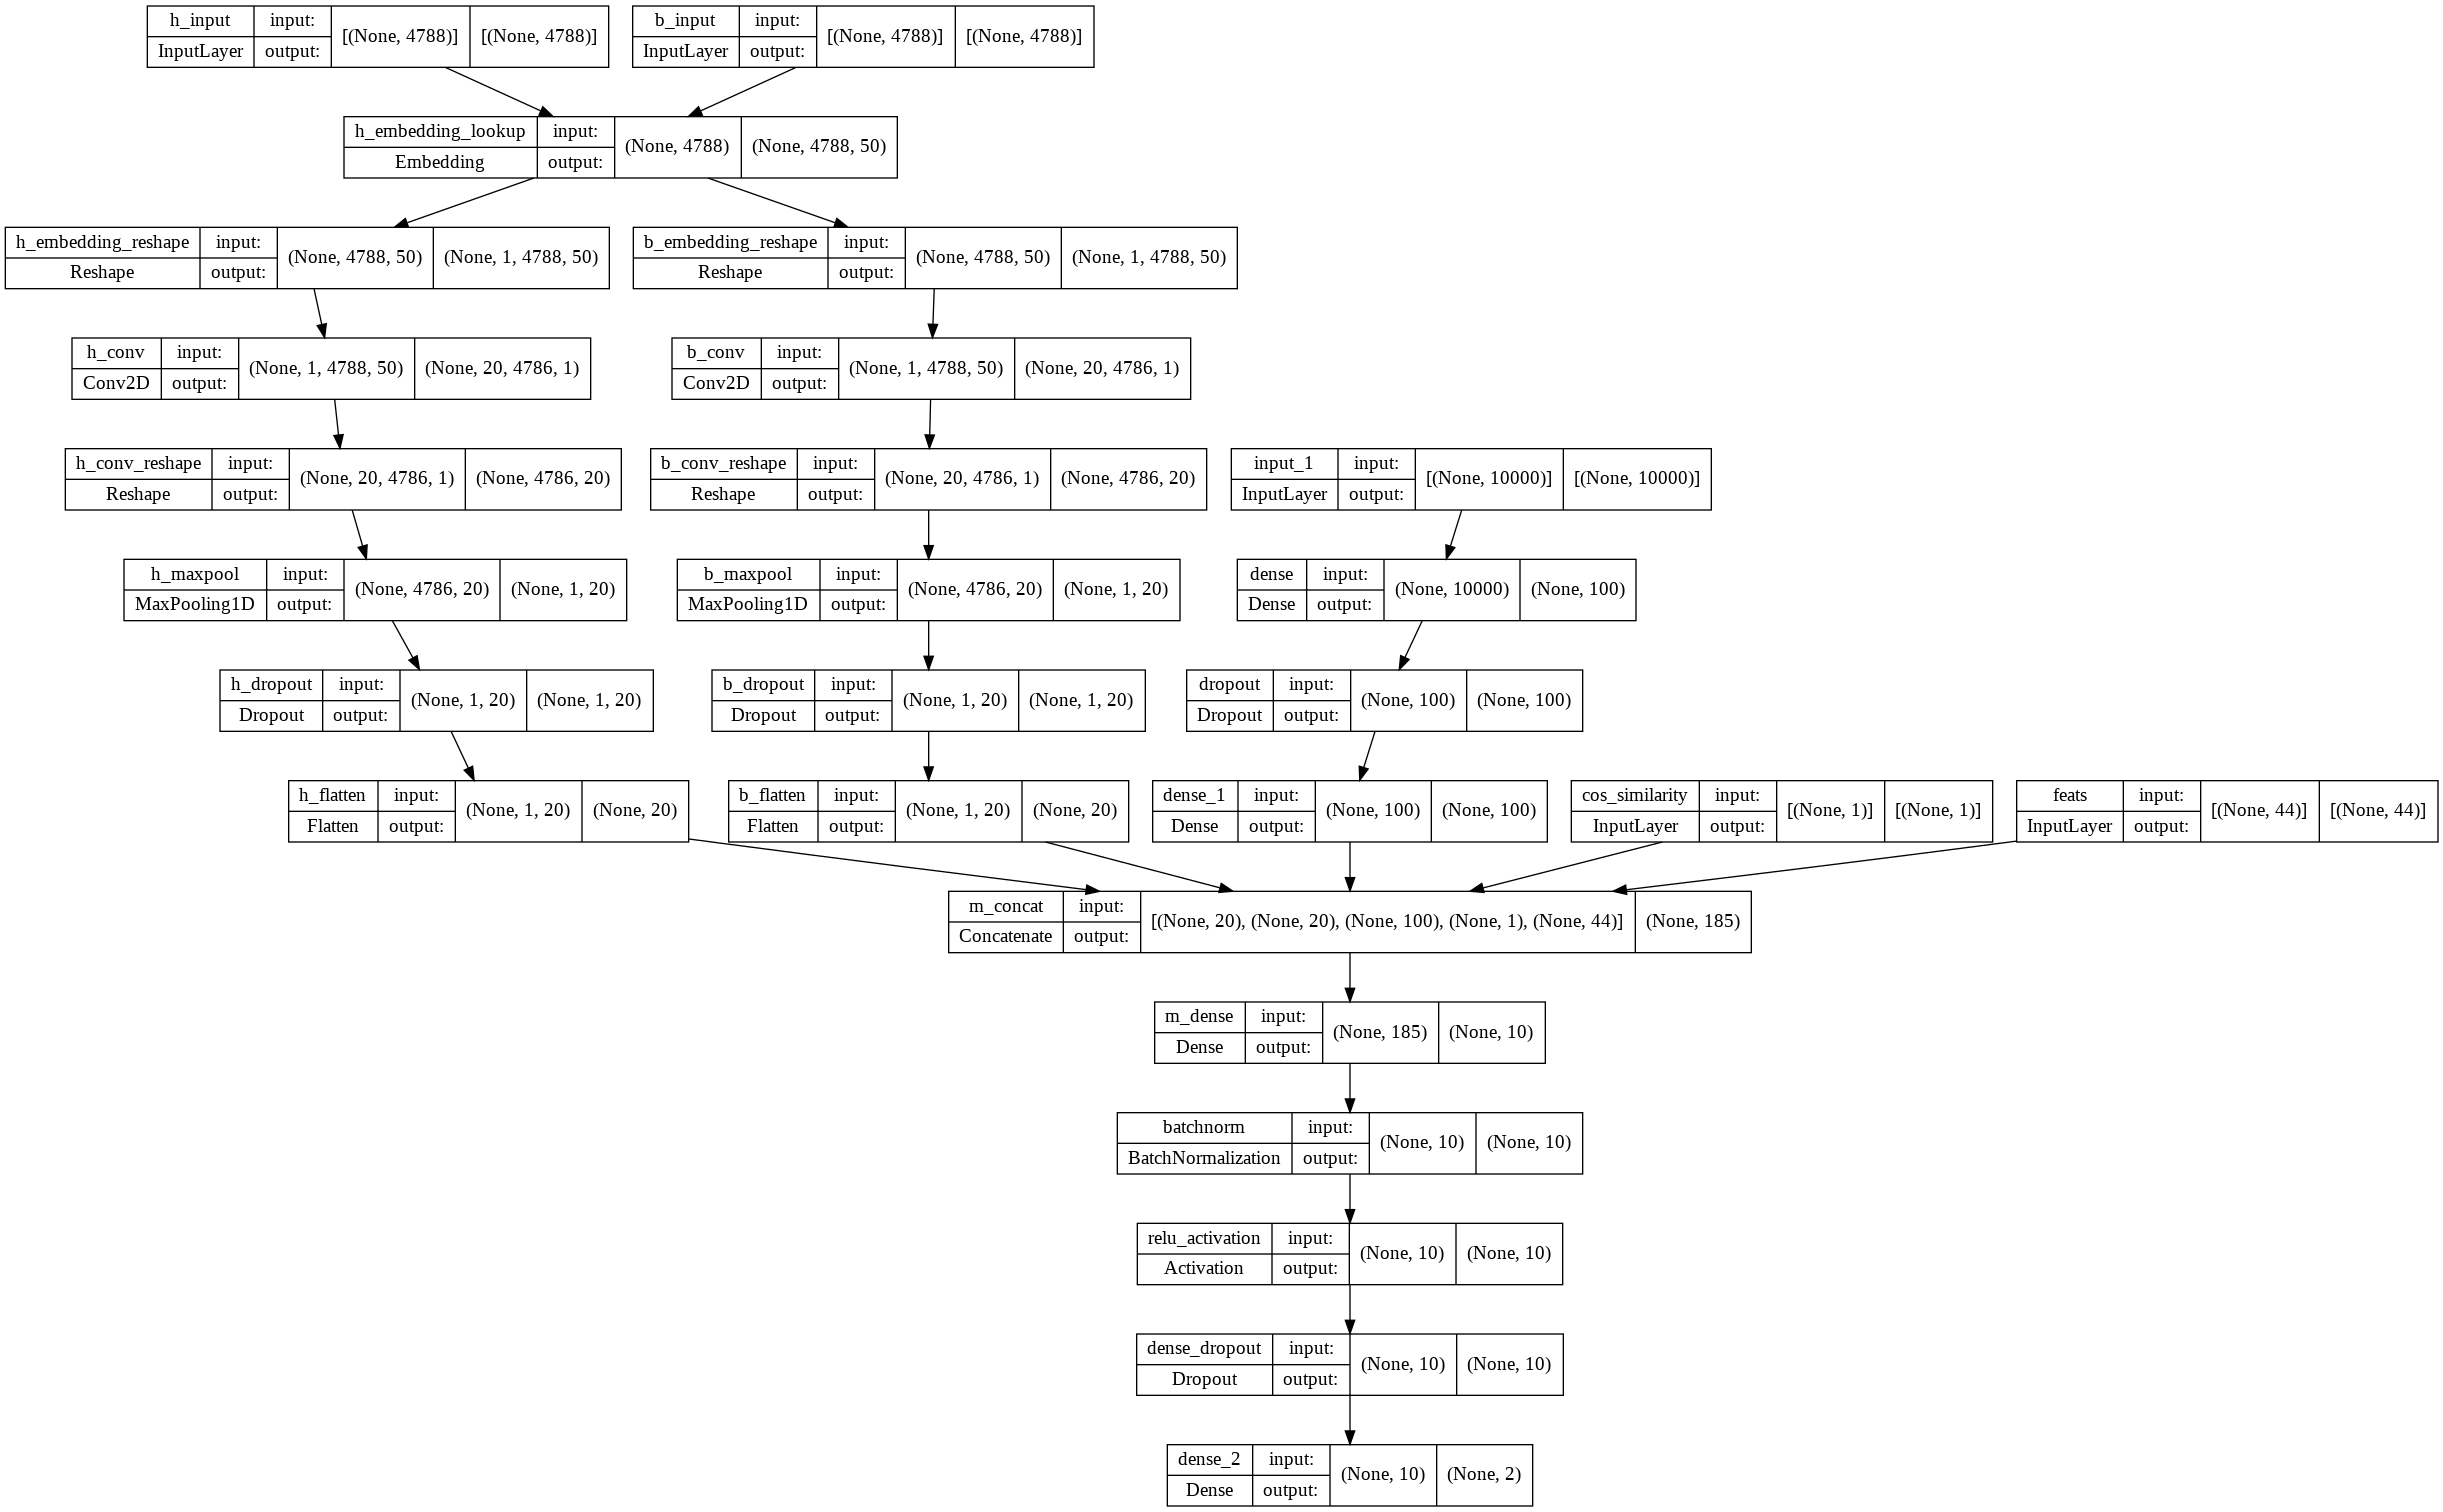

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
BATCH_SIZE = 32
N_EPOCHS = 10

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model.fit(x = [train_h, train_b, train_tf, train_cos], 
#           y = train_s, 
#           batch_size=BATCH_SIZE, 
#           epochs=N_EPOCHS, 
#           validation_data=([val_h, val_b, val_tf, val_cos], val_s))


model.fit(x = [train_h, train_b, train_tf, train_cos, train_feats], 
          y = train_s, 
          batch_size=BATCH_SIZE, 
          epochs=N_EPOCHS, 
          validation_data=([val_h, val_b, val_tf, val_cos, val_feats], val_s))

Epoch 1/10
1780/1780 [==============================] - 70s 34ms/step - loss: 0.3002 - accuracy: 0.8696 - val_loss: 0.0684 - val_accuracy: 0.9851
Epoch 2/10
1780/1780 [==============================] - 59s 33ms/step - loss: 0.0756 - accuracy: 0.9845 - val_loss: 0.0568 - val_accuracy: 0.9907
Epoch 3/10
1780/1780 [==============================] - 59s 33ms/step - loss: 0.0626 - accuracy: 0.9890 - val_loss: 0.0438 - val_accuracy: 0.9946
Epoch 4/10
1780/1780 [==============================] - 60s 34ms/step - loss: 0.0616 - accuracy: 0.9888 - val_loss: 0.0448 - val_accuracy: 0.9953
Epoch 5/10
1780/1780 [==============================] - 60s 34ms/step - loss: 0.0557 - accuracy: 0.9910 - val_loss: 0.0466 - val_accuracy: 0.9937
Epoch 6/10
1780/1780 [==============================] - 60s 34ms/step - loss: 0.0539 - accuracy: 0.9911 - val_loss: 0.0412 - val_accuracy: 0.9956
Epoch 7/10
1780/1780 [==============================] - 60s 34ms/step - loss: 0.0511 - accuracy: 0.9921 - val_loss: 0.0392 -

In [ ]:
model.save('drive/MyDrive/4B/MSCI 598/Project/models/' + 'rel_unrel_cnn_to_nn_8909x3_36545x1')

INFO:tensorflow:Assets written to: drive/MyDrive/4B/MSCI 598/Project/models/rel_unrel_cnn_to_nn_8909x3_36545x1/assets


In [ ]:
score, acc = model.evaluate([test_h, test_b, test_tf, test_cos, test_feats], test_s)
print("acc:",acc)

795/795 [==============================] - 10s 12ms/step - loss: 0.1613 - accuracy: 0.9665
acc: 0.9665132164955139


In [ ]:
from sklearn.metrics import classification_report

y_pro = model.predict([test_h, test_b, test_tf, test_cos, test_feats])
y_classes = y_pro.argmax(axis=-1)
test_s_class_num = []
for t in test_s:
  cur = 0
  if t[0] == 1:
    cur = 0
  elif t[1] == 1:
    cur = 1
  elif t[2] == 1:
    cur = 2
  elif t[3] == 1:
    cur = 3
  test_s_class_num.append(cur)

print(classification_report(test_s_class_num, y_classes))

              precision    recall  f1-score   support

           0       0.49      0.42      0.45      1903
           1       0.00      0.00      0.00       697
           2       0.71      0.79      0.75      4464
           3       0.96      0.99      0.97     18349

    accuracy                           0.88     25413
   macro avg       0.54      0.55      0.54     25413
weighted avg       0.86      0.88      0.87     25413



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
LABELS = ['agree', 'disagree', 'discuss', 'unrelated']
LABELS_RELATED = ['unrelated','related']
RELATED = LABELS[0:3]


predicted = [LABELS[a] for a in y_classes]
actual =[LABELS[a] for a in test_s_class_num]
report_score(actual, predicted)

-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    803    |     0     |    922    |    178    |
-------------------------------------------------------------
| disagree  |    232    |     0     |    308    |    157    |
-------------------------------------------------------------
|  discuss  |    561    |     0     |   3524    |    379    |
-------------------------------------------------------------
| unrelated |    40     |     0     |    192    |   18117   |
-------------------------------------------------------------
Score: 9362.0 out of 11651.25	(80.3518935736509%)


80.3518935736509